# DS-1000 Dataset

https://github.com/xlang-ai/DS-1000 

In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

import os 
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

import src.visualization.plot_rawdata as plotutils

In [2]:
from datasets import load_dataset

dataset = load_dataset("xlangai/DS-1000")
sum([len(dataset[elem]) for elem in dataset.keys()])

1000

In [3]:
dataset.keys()

dict_keys(['test'])

In [4]:
type(dataset['test'])

datasets.arrow_dataset.Dataset

In [5]:
idx = 100
dataset['test'][idx]

{'prompt': "Problem:\nIn pandas, how do I replace &AMP; with '&' from all columns where &AMP could be in any position in a string?\nFor example, in column Title if there is a value 'Good &AMP; bad', how do I replace it with 'Good & bad'?\n\n\nA:\n<code>\nimport pandas as pd\n\n\ndf = pd.DataFrame({'A': ['Good &AMP; bad', 'BB', 'CC', 'DD', 'Good &AMP; bad'], 'B': range(5), 'C': ['Good &AMP; bad'] * 5})\n</code>\ndf = ... # put solution in this variable\nBEGIN SOLUTION\n<code>\n",
 'reference_code': "def g(df):\n    return df.replace('&AMP;','&', regex=True)\n\ndf = g(df.copy())\n",
 'metadata': {'problem_id': 100,
  'library_problem_id': 100,
  'library': 'Pandas',
  'test_case_cnt': 1,
  'perturbation_type': 'Origin',
  'perturbation_origin_id': 100},
 'code_context': 'import pandas as pd\nimport numpy as np\nimport copy\n\n\ndef generate_test_case(test_case_id):\n    def generate_ans(data):\n        df = data\n        return df.replace("&AMP;", "&", regex=True)\n\n    def define_test_

In [6]:
dataset['test'][idx].keys()

dict_keys(['prompt', 'reference_code', 'metadata', 'code_context'])

In [7]:
print(f"The 'test' subset has {len(dataset['test'])} samples")

The 'test' subset has 1000 samples


In [8]:
data = dataset['test']

In [9]:
type(data)

datasets.arrow_dataset.Dataset

In [10]:
type(data)

datasets.arrow_dataset.Dataset

In [11]:
len(data)

1000

#### Check if all elements in data are of type dict and if just one input prompt per data sample (no conversation)

In [12]:
verbose= False

keys = ['prompt', 'reference_code', 'metadata', 'code_context']

for i, elem in enumerate(data):
    if not isinstance(elem, dict):
        print(f"Elem is not a dict! {elem}")
    elif sorted(list(elem.keys())) != sorted(keys):
        print(f"Elem has different keys in dict! {elem.keys()}\n{elem}\n")

### No data

In [13]:
no_conver_data = []

prompt_key = "prompt"

for elem in data: 
    if not elem[prompt_key]:
        no_conver_data.append(elem)
print(f"There are {len(no_conver_data)} elements in the dataset with no prompts!")

There are 0 elements in the dataset with no prompts!


So all of the elements in this dataset have an instruction!

#### Plot conversations lengths (number of tokens of first human input)

In [14]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
padding_side='left'

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)



## Input handling
Each sample in the dataset is of type `dict`.
The keys of that `dict` are `['prompt', 'reference_code', 'metadata', 'code_context']`. 

However, the tokenizers' `chat_templates` do not recognize those keyas, so we need to append it to the user's `content`.  

In [15]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [16]:
from src.data.rawdata_processor import ds1000_generate_rawprompt_text, build_rawprompt_text_chat, build_rawprompt_text_batch

In [17]:
mystring = ds1000_generate_rawprompt_text(data[233], tokenizer, truncate=False)
print(mystring)

Problem:
I have the following dataframe:
  text
1 "abc" 
2 "def" 
3 "ghi"
4 "jkl" 


How can I merge these rows into a dataframe with a single row like the following one?
  text 
1 "abc-def-ghi-jkl"

A:
<code>
import pandas as pd


df = pd.DataFrame({'text': ['abc', 'def', 'ghi', 'jkl']})
</code>
result = ... # put solution in this variable
BEGIN SOLUTION
<code>



In [18]:
build_rawprompt_text_chat(mystring)

[{'role': 'user',
  'content': 'Problem:\nI have the following dataframe:\n  text\n1 "abc" \n2 "def" \n3 "ghi"\n4 "jkl" \n\n\nHow can I merge these rows into a dataframe with a single row like the following one?\n  text \n1 "abc-def-ghi-jkl"\n\nA:\n<code>\nimport pandas as pd\n\n\ndf = pd.DataFrame({\'text\': [\'abc\', \'def\', \'ghi\', \'jkl\']})\n</code>\nresult = ... # put solution in this variable\nBEGIN SOLUTION\n<code>\n'}]

In [19]:
get_tokens(build_rawprompt_text_chat(mystring), tokenizer).shape

torch.Size([1, 146])

In [20]:
print(tokenizer.decode(get_tokens(build_rawprompt_text_batch(mystring, 5), tokenizer)[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

Problem:
I have the following dataframe:
  text
1 "abc" 
2 "def" 
3 "ghi"
4 "jkl" 


How can I merge these rows into a dataframe with a single row like the following one?
  text 
1 "abc-def-ghi-jkl"

A:
<code>
import pandas as pd


df = pd.DataFrame({'text': ['abc', 'def', 'ghi', 'jkl']})
</code>
result =... # put solution in this variable
BEGIN SOLUTION
<code><|eot_id|><|start_header_id|>assistant<|end_header_id|>




### Analyze lenght of prompts in terms of number of tokens

In [21]:
conv_len_tokens = [get_tokens(build_rawprompt_text_chat(ds1000_generate_rawprompt_text(elem, tokenizer, truncate=False)), 
                              tokenizer).shape[1] for elem in data]

In [22]:
len(conv_len_tokens)

1000

In [23]:
np.max(conv_len_tokens)

np.int64(2109)

In [27]:
print(f"MEAN: {np.mean(conv_len_tokens)}\nMIN: {np.min(conv_len_tokens)},\nMAX: {np.max(conv_len_tokens)}")
print(*[f"P{p}: {v:.2f}" for p, v in zip([25, 50, 75, 99], np.percentile(conv_len_tokens, [25, 50, 75, 99]))])

MEAN: 317.241
MIN: 67,
MAX: 2109
P25: 170.50 P50: 283.00 P75: 395.00 P99: 1018.29


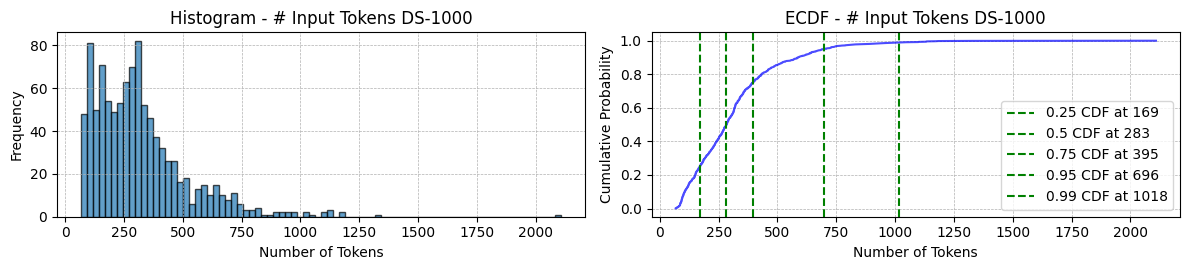

In [28]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(12, 2.8), 
                             in_title="# Input Tokens DS-1000", x_forcdf=0, 
                                       cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99],
                                      n_bins=80)

In [29]:
fig.savefig("../../outputs/images/raw_data_DS1000_ntokens_hist.pdf", bbox_inches="tight")

# Split the datasets

In [29]:
SEED = 42
MAXIMUM = 2000

In [30]:
np.random.seed(SEED)

In [31]:
tmp = np.arange(len(data))
np.random.shuffle(tmp)

In [32]:
idx_subset = min(MAXIMUM, len(data))
tmp = tmp[0:idx_subset]
print(f"SELECTING {len(tmp)} samples randomly from dataset")

SELECTING 1000 samples randomly from dataset


In [33]:
train_indxs, val_indxs, test_indxs = np.split(tmp, [int(0.7*len(tmp)), int(0.9*len(tmp))])

In [34]:
print(f"Selecting {len(train_indxs)} training, {len(val_indxs)} validation, and {len(test_indxs)} test samples")

Selecting 700 training, 200 validation, and 100 test samples


In [35]:
data_train = [data[int(i)] for i in train_indxs]
data_val = [data[int(i)] for i in val_indxs]
data_test = [data[int(i)] for i in test_indxs]

In [36]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.7
Percentage of validation data: 0.2
Percentage of test data: 0.1


## Save Datasets

In [37]:
def save_data(dataset, path):
    with open(path, 'w') as f:
        json.dump(dataset, f)
    print(f"Dataset saved to path {path}")

In [38]:
save_path_src = "../raw_instruct/DS1000/raw_DS1000"

In [39]:
save_data(data_train, save_path_src + "_train.json")

Dataset saved to path ../raw_instruct/DS1000/raw_DS1000_train.json


In [40]:
save_data(data_val, save_path_src + "_validate.json")

Dataset saved to path ../raw_instruct/DS1000/raw_DS1000_validate.json


In [41]:
save_data(data_test, save_path_src + "_test.json")

Dataset saved to path ../raw_instruct/DS1000/raw_DS1000_test.json
